# Synthesis for linear connectivity

Qiskit issue (epic): https://github.com/Qiskit/qiskit/issues/9036

Contributors: Shelly Garion, Alexander Ivrii, Ben Zindorff and Willers Yang

In [38]:
import numpy as np
import qiskit
from qiskit import QuantumCircuit
from qiskit import transpile
from qiskit.providers.fake_provider import FakeManhattanV2

from qiskit.circuit.library import *
from qiskit.synthesis import *
from qiskit.quantum_info import *
from qiskit.synthesis.linear import random_invertible_binary_matrix

### Why do we need synthesis for linear connectivity?

First option:
Generate a random Clifford on 50 qubits, decompose it using the greedy Clifford compiler, and transpile it for a heavy-hex device

In [5]:
cliff = random_clifford(50)

In [67]:
device = FakeManhattanV2()  # 65 qubits
num_qubits = device.num_qubits
coupling_map = device.coupling_map

qc = synth_clifford_greedy(cliff)

print(f"original circuit has: "
      f"2q-depth {qc.depth(filter_function=lambda x: x.operation.num_qubits == 2)}, "
      f"2q-count {qc.size(filter_function=lambda x: x.operation.num_qubits == 2)}, "
      f"1q-count {qc.size(filter_function=lambda x: x.operation.num_qubits == 1)}. ")

original circuit has: 2q-depth 695, 2q-count 1265, 1q-count 1147. 


In [68]:
qc_trans = transpile(qc, basis_gates = ['rz', 'sx', 'cx'], coupling_map = edges, optimization_level = 3)

print(f"transpiled circuit has: "
      f"2q-depth {qc_trans.depth(filter_function=lambda x: x.operation.num_qubits == 2)}, "
      f"2q-count {qc_trans.size(filter_function=lambda x: x.operation.num_qubits == 2)}, "
      f"1q-count {qc_trans.size(filter_function=lambda x: x.operation.num_qubits == 1)}. ")

transpiled circuit has: 2q-depth 4320, 2q-count 12051, 1q-count 3759. 


Second option: Decompose the Clifford for linear neares neighbor (LNN) connectivity, and embed the line inside the heavy hex

In [69]:
qc_lnn = synth_clifford_depth_lnn(cliff).decompose()

print(f"LNN circuit has: "
      f"2q-depth {qc_lnn.depth(filter_function=lambda x: x.operation.num_qubits == 2)}, "
      f"2q-count {qc_lnn.size(filter_function=lambda x: x.operation.num_qubits == 2)}, "
      f"1q-count {qc_lnn.size(filter_function=lambda x: x.operation.num_qubits == 1)}. ")

LNN circuit has: 2q-depth 340, 2q-count 7316, 1q-count 2204. 


In [75]:
# layout is a line of connected qubits
layout = [9, 8, 7, 6, 5, 4, 3, 2, 1, 0, 10,
          13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 26,
          37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 38,
          41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 54,
          64, 63, 62, 61, 60, 59, 58, 57, 56, 55]
num_qubits = qc_lnn.num_qubits
initial_layout = layout[0:num_qubits]

qc_lnn_trans = transpile(qc_lnn, coupling_map=coupling_map, basis_gates=['rz', 'sx', 'cx'], 
                         optimization_level=1, initial_layout=initial_layout)

print(f"transpiled LNN circuit has: "
      f"2q-depth {qc_lnn_trans.depth(filter_function=lambda x: x.operation.num_qubits == 2)}, "
      f"2q-count {qc_lnn_trans.size(filter_function=lambda x: x.operation.num_qubits == 2)}, "
      f"1q-count {qc_lnn_trans.size(filter_function=lambda x: x.operation.num_qubits == 1)}. ")

transpiled LNN circuit has: 2q-depth 340, 2q-count 7316, 1q-count 2265. 


We have reduced the 2q-depth by factor 10-20 and 2q-count by factor 2 after transpilation!

## Synthesis algorithms for linear connectivity

### Linear circuits in depth 5n

Reference

1. Kutin, S., Moulton, D. P., Smithline, L., Computation at a distance, Chicago J. Theor. Comput. Sci., vol. 2007, (2007), arXiv:quant-ph/0701194

In [66]:
num_qubits = 50
# input: random invertible binary matrix
mat = random_invertible_binary_matrix(num_qubits)
qc = synth_cnot_depth_line_kms(mat)

print(f"Linear circuit has: "
      f"2q-depth {qc.depth(filter_function=lambda x: x.operation.num_qubits == 2)}, "
      f"2q-count {qc.size(filter_function=lambda x: x.operation.num_qubits == 2)}, "
      f"1q-count {qc.size(filter_function=lambda x: x.operation.num_qubits == 1)}. ")

Linear circuit has: 2q-depth 237, 2q-count 4795, 1q-count 0. 


### Linear circuits in depth 3n (or n of swap gates)

Reference

1. Kutin, S., Moulton, D. P., Smithline, L., Computation at a distance, Chicago J. Theor. Comput. Sci., vol. 2007, (2007), arXiv:quant-ph/0701194

In [71]:
num_qubits = 50
# input: random permutation
pattern = np.random.permutation(num_qubits)
qc = synth_permutation_depth_lnn_kms(pattern)

print(f"Permutation circuit has: "
      f"2q-depth {qc.depth(filter_function=lambda x: x.operation.num_qubits == 2)}, "
      f"2q-count {qc.size(filter_function=lambda x: x.operation.num_qubits == 2)}, "
      f"1q-count {qc.size(filter_function=lambda x: x.operation.num_qubits == 1)}. ")

Permutation circuit has: 2q-depth 40, 2q-count 652, 1q-count 0. 


### CZ circuits in depth 2n+2 

Note that this method reverts the order of qubits in the circuit, and returns a circuit containing CX and phase (S, Sdg or Z) gates.

Reference

1. Dmitri Maslov, Martin Roetteler, Shorter stabilizer circuits via Bruhat decomposition and quantum circuit transformations, arXiv:1705.09176.

In [72]:
num_qubits = 50
# input: an upper-diagonal matrix representing the CZ circuit. mat[i][j]=1 for i<j represents a CZ(i,j) gate
qc = synth_cz_depth_line_mr(mat)

print(f"CZ circuit has: "
      f"2q-depth {qc.depth(filter_function=lambda x: x.operation.num_qubits == 2)}, "
      f"2q-count {qc.size(filter_function=lambda x: x.operation.num_qubits == 2)}, "
      f"1q-count {qc.size(filter_function=lambda x: x.operation.num_qubits == 1)}. ")

CZ circuit has: 2q-depth 102, 2q-count 2499, 1q-count 1104. 


### Clifford circuits in depth 7n+2

The depth of the synthesized n-qubit Clifford circuit is bounded by 7n+2, which is not optimal. It should be replaced by a better algorithm that provides depth bounded by 7n-4

References

1. S. Bravyi, D. Maslov, Hadamard-free circuits expose the structure of the Clifford group, arXiv:2003.09412 [quant-ph]

2. Dmitri Maslov, Martin Roetteler, Shorter stabilizer circuits via Bruhat decomposition and quantum circuit transformations, arXiv:1705.09176.

3. Dmitri Maslov, Willers Yang, CNOT circuits need little help to implement arbitrary Hadamard-free Clifford transformations they generate, arXiv:2210.16195.

 First step: decompose the Clifford into layers according to [1]
 

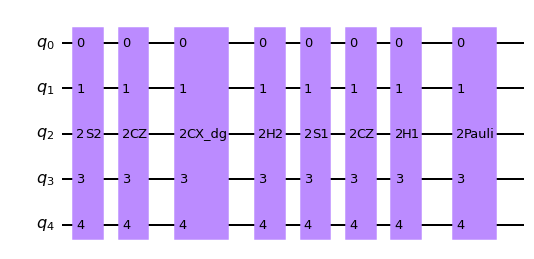

In [46]:
cliff = random_clifford(5)
qc = synth_clifford_layers(cliff)

qc.draw('mpl')

Second step: decompose the CZ layer in depth 2n+2 according to [2] and the CX-CZ layers in depth 5n according to [3], providing a total depth of 7n+2.

Further local optimizations from [3] could be used to improve the depth to 7n-4.

In [73]:
cliff = random_clifford(50)
qc = synth_clifford_depth_lnn(cliff).decompose()

print(f"Clifford circuit has: "
      f"2q-depth {qc.depth(filter_function=lambda x: x.operation.num_qubits == 2)}, "
      f"2q-count {qc.size(filter_function=lambda x: x.operation.num_qubits == 2)}, "
      f"1q-count {qc.size(filter_function=lambda x: x.operation.num_qubits == 1)}. ")

Clifford circuit has: 2q-depth 341, 2q-count 7300, 1q-count 2200. 


###  Stabilizer circuits in depth 2n+2

References

1. S. Bravyi, D. Maslov, Hadamard-free circuits expose the structure of the Clifford group, arXiv:2003.09412 [quant-ph]

2. Dmitri Maslov, Martin Roetteler, Shorter stabilizer circuits via Bruhat decomposition and quantum circuit transformations, arXiv:1705.09176.


First step: decompose the stabilizer state into layers according to [1]

It provides a similar decomposition to the synthesis of a Clifford, without the initial Hadamard-free sub-circuit which do not affect the stabilizer state.

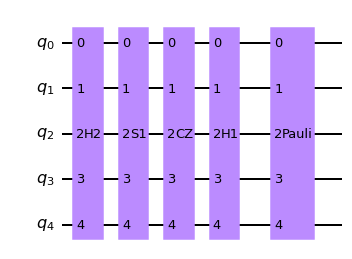

In [50]:
cliff = random_clifford(5)
stab = StabilizerState(cliff)
qc = synth_stabilizer_layers(stab)

qc.draw('mpl')

Second step: decompose the CZ layer in depth 2n+2 according to [2] 

In [74]:
cliff = random_clifford(50)
stab = StabilizerState(cliff)
qc = synth_stabilizer_depth_lnn(stab).decompose()

print(f"Stabilizer circuit has: "
      f"2q-depth {qc.depth(filter_function=lambda x: x.operation.num_qubits == 2)}, "
      f"2q-count {qc.size(filter_function=lambda x: x.operation.num_qubits == 2)}, "
      f"1q-count {qc.size(filter_function=lambda x: x.operation.num_qubits == 1)}. ")

Stabilizer circuit has: 2q-depth 102, 2q-count 2499, 1q-count 1213. 


## Further work

1. Improve Clifford synthesis depth from 7n+2 to 7n-4 by using local optimizations

2. Add furhter synthesis algorithms for linear connectivity, e.g. QFT

3. Add further synthesis algorithms for general connectivity, in particular, grid and heavy-hex